<a href="https://colab.research.google.com/github/brenoafb/video-compression/blob/Giordano/NoteCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
!pip install bitstring
!pip install --upgrade Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)


In [101]:
%reload_ext autoreload
%autoreload 2

Includes

In [102]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import bitstring as bs
from yuv_reader import read_yuv
from block_utils import *
from compression import *
from img_utils import *
from coding import *
import io

Informações sobre o vídeo: nome e dimensõe

In [103]:
filename = 'foreman_qcif.yuv'
width = 176
height = 144

In [104]:
frames = read_yuv(filename)
#frames

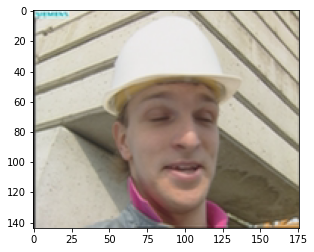

In [105]:
plt.imshow(frames[1])

In [106]:
 #for frame in frames: 
  #cv2_imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
   
    # Press Q on keyboard to  exit
  #if cv2.waitKey(25) & 0xFF == ord('q'):
    #break

In [107]:
frame = frames[1]
frame.shape

(144, 176, 3)

In [108]:
#locks_per_row, blocks_per_column

In [109]:
block_size = 16
blocks = get_blocks(frame, block_size)
for (block, coords) in blocks:
    #plt.imshow(block)
    #print(coords)
    plt.show()

In [110]:
(block, coords) = blocks[43]
#plt.imshow(block), print(coords)

In [111]:
delta = 10
mat = frames[0]
found_coords = get_matching_block(mat, block, coords[0], coords[1], delta)

In [112]:
found_block = mat[found_coords[0] : found_coords[0] + block_size, found_coords[1] : found_coords[1] + block_size, :]
#plt.imshow(found_block)

In [113]:
residual = block - found_block
#plt.imshow(residual)

In [114]:
residuals = []
motion_vectors = []
for (block, coords) in blocks:
    found_coords = get_matching_block(mat, block, coords[0], coords[1], delta)
    found_block = mat[found_coords[0] : found_coords[0] + block_size,
                      found_coords[1] : found_coords[1] + block_size,
                      :]
    motion_vector = (coords[0] - found_coords[0], coords[1] - found_coords[1])
    residual = block.astype(np.float32) - found_block.astype(np.float32)
    residuals.append((residual, coords))
    motion_vectors.append(motion_vector)

In [115]:
residual = blocks_to_frame(residuals, height, width)

In [116]:
residual.min(), residual.max()

(0, 255)

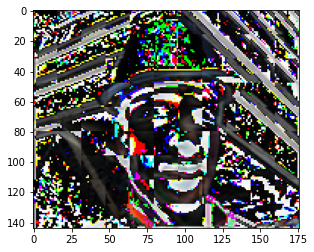

In [117]:
residual, vmin, vmax = scale_to_img(residual)
plt.imshow(residual)
im = Image.fromarray(residual)
im.save("res.jpg")

In [118]:
#residuals -= residuals.min()

In [119]:
#residuals /= residuals.max()

In [120]:
#residuals *= 255
#residuals = residuals.astype(np.uint8)
#residuals

In [121]:
#plt.imshow(residuals), residuals.shape

Códigos a seguir somente para testar as funções:


In [122]:
padding = 0
with open('vectors.em', 'wb') as f:
    bits = writeVector(motion_vectors, bs.Bits(bin= '0b'))
    padding = (8 - (bits.len % 8)) % 8
    bits.tofile(f)

In [123]:
bits = bs.Bits(filename= 'vectors.em')

if padding != 0:
  bits = bits[:-padding]

vector = []
num_blocks = 144//16 * 176//16

for i in range(num_blocks):
  bits, value1 = readNumber(bits)
  bits, value2 = readNumber(bits)
  vector.append((value1, value2))

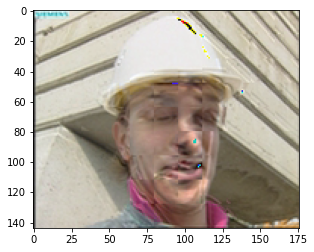

In [124]:
next_frame = build_frame(frame, residual, motion_vectors, block_size)
plt.imshow(next_frame)

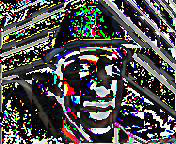

In [125]:
filename = "video.vid"
with open(filename, "wb") as f:
  writeFrame(f, residual, motion_vectors, vmin, vmax)

video_bytes = b''
with open(filename, "rb") as f:
  video_bytes = f.read()

while (video_bytes != b''):
  vector, vmin_n, vmax_n, img, video_bytes = getFrame(video_bytes)
  img.show()